In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
bounds = {'pi': {'max': 0, 'min':-16, 'dim':10}, 'phi': {'max': -.15, 'min':-.45, 'dim':10}, 
          'theta': {'max':6, 'min': 0, 'dim':10}}
innov_dim = 500

In [5]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 40
    vol = store['discrete_vol_est'] * 40**2
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,1.018986,0.221712
2003-01-03,0.085707,0.196170
2003-01-06,0.817542,0.115554
2003-01-07,-0.142341,0.208983
2003-01-08,-0.436209,0.162428


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,0.139160,-0.005791
vol,-0.005791,0.047533


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.003718,0.141630
std,0.373042,0.364284
min,-3.298704,0.003107
25%,-0.151435,0.034785
50%,0.020365,0.060872
75%,0.174527,0.126756
max,2.862066,10.629397


In [11]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.003718,0.141630
std,0.373042,0.364284
min,-3.298704,0.003107
25%,-0.151435,0.034785
50%,0.020365,0.060872
75%,0.174527,0.126756
max,2.862066,10.629397


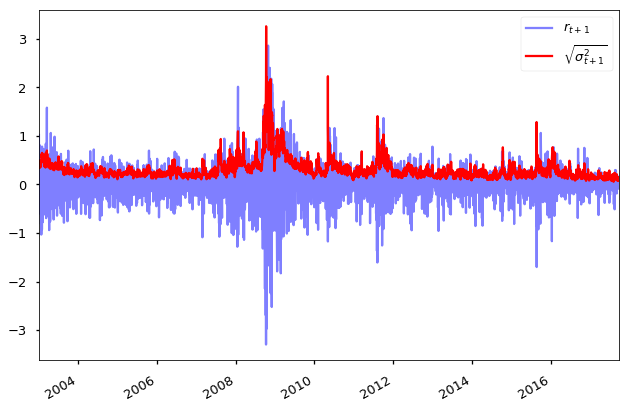

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

(None,)

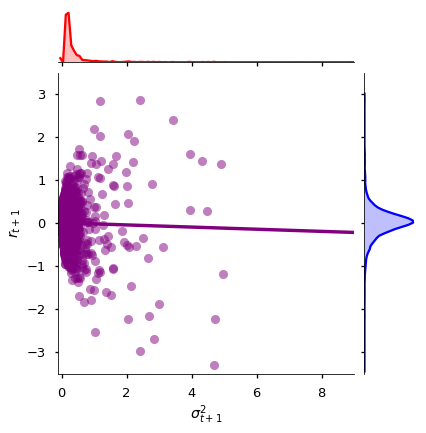

In [13]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data, xlim=[-.1, 9], ylim=[-3.5, 3.5])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True),

In [14]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [15]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol))

In [16]:
estimates

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667}

In [17]:
covariance

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.003869,-0.000035,0.000000,0.000000,0.000000,-0.003624,0.000000
gamma,-0.000035,0.000016,0.000000,0.000000,0.000000,-0.000080,0.000000
log_both,0.000000,0.000000,0.016276,0.014685,-0.026087,0.000000,0.000000
log_scale,0.000000,0.000000,0.014685,0.213271,0.008542,0.000000,0.000000
logit_rho,0.000000,0.000000,-0.026087,0.008542,0.051510,0.000000,0.000000
psi,-0.003624,-0.000080,0.000000,0.000000,0.000000,0.005924,0.000000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000431


In [18]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.003107
2017-09-14    0.005409
2017-09-22    0.005464
2016-11-25    0.005700
2017-07-24    0.006115
Name: vol, dtype: float64

In [19]:
omega2, omega_cov2 = vl.estimate_params(data)

In [20]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=bounds['theta']['dim'],
                               pi_dim=bounds['pi']['dim'], phi_dim=bounds['phi']['dim'],
                               pi_min=bounds['pi']['min'], pi_max=bounds['pi']['max'], 
                               phi_min=bounds['phi']['min'], phi_max=bounds['phi']['max'],
                               theta_min=bounds['theta']['min'], theta_max=bounds['theta']['max'],
                                 use_tqdm=True)

In [21]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=bounds['theta']['dim'],
                               pi_dim=bounds['pi']['dim'], phi_dim=bounds['phi']['dim'],
                               pi_min=bounds['pi']['min'], pi_max=bounds['pi']['max'], 
                               phi_min=bounds['phi']['min'], phi_max=bounds['phi']['max'],
                               theta_min=bounds['theta']['min'], theta_max=bounds['theta']['max'],
                               use_tqdm=True, alpha=0.05, innov_dim=innov_dim)

In [47]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.400000,-16.000000,0.555556,0.0
1,-0.400000,-16.000000,0.000000,0.0
10,-0.400000,-14.222222,1.111111,0.0
100,-0.377778,-16.000000,3.888889,0.0
101,-0.377778,-16.000000,4.444444,0.0


In [23]:
qlr_draws.head()

,phi,pi,theta,qlr
1,-0.4,-16.0,0.000000,0.0
0,-0.4,-16.0,0.555556,0.0
3,-0.4,-16.0,1.111111,0.0
2,-0.4,-16.0,1.666667,0.0
5,-0.4,-16.0,2.222222,0.0


In [24]:
qlr_stats.count()

phi      1000
pi       1000
theta    1000
qlr      1000
dtype: int64

In [30]:
merged_values = vl.merge_draws_and_sims(qlr_stats, qlr_draws)

In [32]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [34]:
qlr_draws.to_json(f'../results/qlr_draws_on_da-.9ta_{innov_dim}_smaller_region_flattened.tmp.json')

In [35]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [36]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.400000,-16.000000,0.555556,0.0
1,-0.400000,-16.000000,0.000000,0.0
10,-0.400000,-14.222222,1.111111,0.0
100,-0.377778,-16.000000,3.888889,0.0
101,-0.377778,-16.000000,4.444444,0.0


In [37]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [38]:
omega

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667,
 'phi': -0.32101012538519297,
 'pi': -2.5456201455253147e-19,
 'theta': 0.33711166708226764}

In [46]:
accepted_vals.head()

,phi,pi,theta
280,-0.355556,-5.333333,2.222222
341,-0.333333,-8.888889,1.666667
351,-0.333333,-7.111111,0.000000
361,-0.333333,-5.333333,0.000000
380,-0.333333,-1.777778,0.000000


In [40]:
accepted_vals.min()

phi      -0.355556
pi      -12.444444
theta     0.000000
dtype: float64

In [48]:
accepted_vals.max()

phi     -0.222222
pi       0.000000
theta    4.444444
dtype: float64

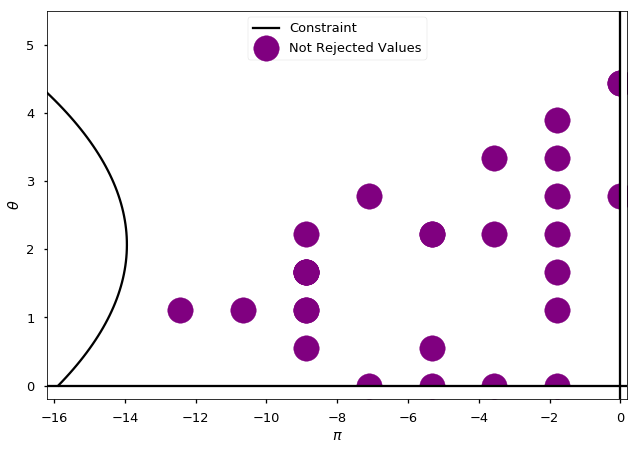

In [41]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=650, label='Not Rejected Values',
           color='purple')

max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

yvals = np.linspace(0,max_y+1,100)
xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=0, ymax=1, color='black')
ax3.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((min_x-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect1)
ax3.add_patch(white_rect2)
ax3.set_ylim([-.2, max_y+.5])
ax3.set_xlim([min_x - .2, .2])
ax3.set_ylabel(r'$\theta$')
ax3.set_xlabel(r'$\pi$')
ax3.legend(loc='upper center')

fig3.savefig(f'../doc/figures/confidence_region_{innov_dim}.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [42]:
qlr_draws_pivoted = qlr_draws[np.isclose(qlr_draws.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr')

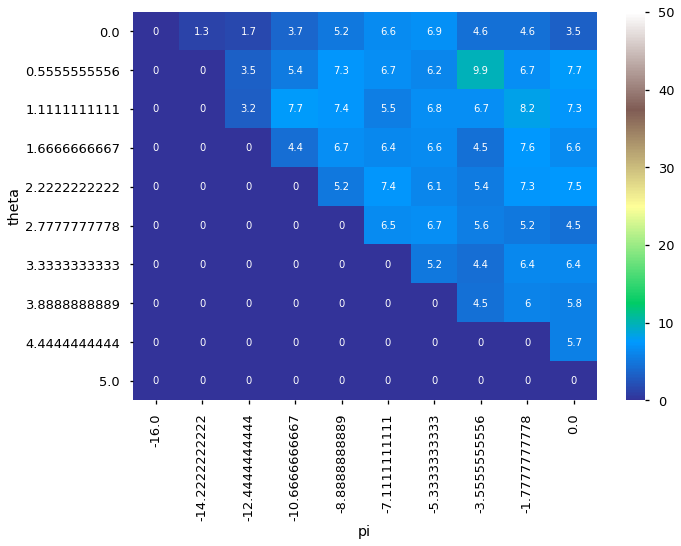

In [43]:
sns.heatmap(qlr_draws_pivoted, annot=True,  cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)

In [44]:
qlr_stats_pivoted = qlr_stats[np.isclose(qlr_stats.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(axis='index')

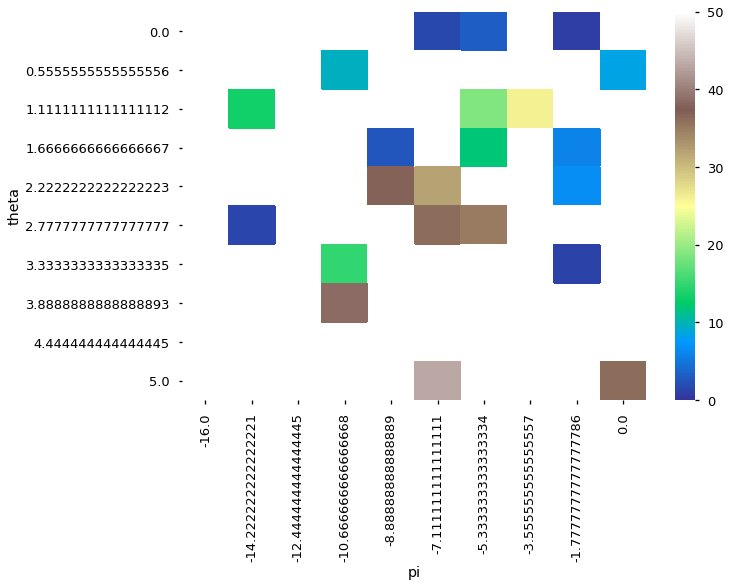

In [45]:
sns.heatmap(qlr_stats_pivoted, annot=False, cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)